In [2]:
import torch
from models.CustomSD import CustomSDPipeline
from models.CustomUNet2DCM import CustomUNet2DConditionModel
from compel import Compel
from pathlib import Path

In [4]:
def setup_pipeline(model_id: str, device: torch.device) -> CustomSDPipeline:
    """Set up the Stable Diffusion pipeline."""
    pipeline = CustomSDPipeline.from_pretrained(
        model_id,
        torch_dtype=torch.float16,
        safety_checker=None,
        variant="fp16",
        disable_progress_bar=True,
    )
    
    custom_unet = CustomUNet2DConditionModel(**pipeline.unet.config)
    custom_unet.load_state_dict(pipeline.unet.state_dict())
    pipeline.unet = custom_unet
    pipeline = pipeline.to(device, dtype=torch.float16)
    
    return pipeline

# Fixed parameters
model_id = "stable-diffusion-v1-5/stable-diffusion-v1-5"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
steps = 45
guidance_scale = 8.0

# Setup pipeline
pipeline = setup_pipeline(model_id, device)

Keyword arguments {'disable_progress_bar': True} are not expected by CustomSDPipeline and will be ignored.
Loading pipeline components...: 100%|██████████| 6/6 [00:06<00:00,  1.07s/it]
You have disabled the safety checker for <class 'models.CustomSD.CustomSDPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


100%|██████████| 45/45 [00:02<00:00, 22.20it/s]


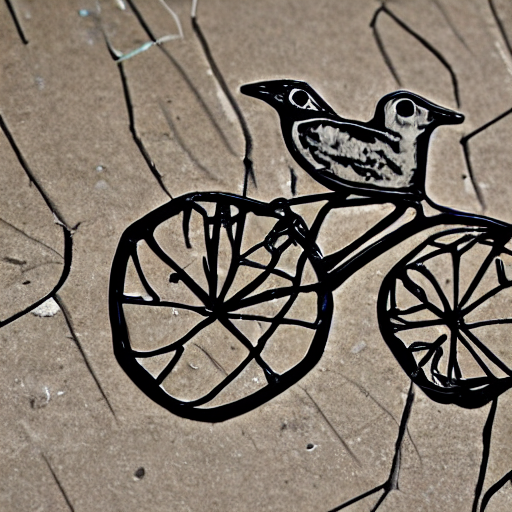

: 

In [15]:
# Setup Compel processor
compel_proc = Compel(tokenizer=pipeline.tokenizer, text_encoder=pipeline.text_encoder)

# Generate prompts and embeddings
prompt1 = "bird"
prompt2 = "bicycle"
encoder_embedding = compel_proc(prompt1)
decoder_embedding = compel_proc(prompt2)

# Generate the image
image = pipeline(
    prompt_embeds=encoder_embedding,
    prompt_embeds_2=decoder_embedding,
    num_inference_steps=steps,
    guidance_scale=guidance_scale,
).images[0]

image